## Lawrence Abdulnour (20019894), Alexandre Marcil (C9464) and Louis-François Préville-Ratelle (708048)

#Q2 Practical Part

## We used tp11 from last semester  (Ioannis' class) as a  starting point to design our networks.

In [0]:
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms


import gzip
import pickle
import numpy as np
np.random.seed(0)
import random
from random import seed
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import time

In [0]:
### MNIST download ###
#!wget http://deeplearning.net/data/mnist/mnist.pkl.gz
#import pickle, gzip, numpy as np

# Load the dataset
#f = gzip.open('mnist.pkl.gz', 'rb')
#train_set, valid_set, test_set = pickle.load(f, encoding="bytes")
#f.close()

In [0]:
print(f"Your version of Pytorch is {torch.__version__}")

Your version of Pytorch is 1.0.1.post2


In [0]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


In [0]:
# dataset

train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # Standardize with mean and std computed on train set
                       transforms.Normalize((0.1307,), (0.3081,)),
                   ]))

test_data = datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))



Processing...
Done!


In [0]:
# size of the scratch training set
n_scratch = 64

# This parameter influences optimization
batch_size = 64
# This is just for evaluation, we want is as big as the GPU can support
batch_size_eval = 512


indices = list(range(len(train_data)))
random.shuffle(indices)

In [0]:
# DataLoaders

# This is the subset of MNIST we want to overfit
scratch_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    # The sampler is an easy way to say that we're using the elements
    # `indices[:n_scratch]` for this loader
    sampler=SubsetRandomSampler(indices[:n_scratch]),
    num_workers=1,
    pin_memory=use_cuda
)

# TODO: define a train, valid and test loader
# size of the validation set
n_valid = 10000

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[n_valid:]),
    #num_workers=1,
    pin_memory=use_cuda
)

valid_loader = DataLoader(
    train_data,
    batch_size=batch_size_eval,
    sampler=SubsetRandomSampler(indices[:n_valid]),
    #num_workers=1,
    pin_memory=use_cuda,
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size_eval,
    #num_workers=1,
    pin_memory=use_cuda,
)

In [0]:
print(len(test_data))

10000


target torch.Size([64]) [tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(3), tensor(8), tensor(4), tensor(5), tensor(8), tensor(8), tensor(2), tensor(1), tensor(0), tensor(7), tensor(6), tensor(9), tensor(2), tensor(8), tensor(7), tensor(9), tensor(3), tensor(0), tensor(6), tensor(5), tensor(8), tensor(7), tensor(1), tensor(8), tensor(1), tensor(1), tensor(9), tensor(1), tensor(0), tensor(3), tensor(4), tensor(8), tensor(2), tensor(9), tensor(7), tensor(6), tensor(1), tensor(8), tensor(4), tensor(0), tensor(5), tensor(7), tensor(1), tensor(5), tensor(0), tensor(0), tensor(3), tensor(6), tensor(3), tensor(8), tensor(2), tensor(5), tensor(1), tensor(9), tensor(1), tensor(7), tensor(1), tensor(8), tensor(5)]
torch.Size([28, 28])
tensor(6)


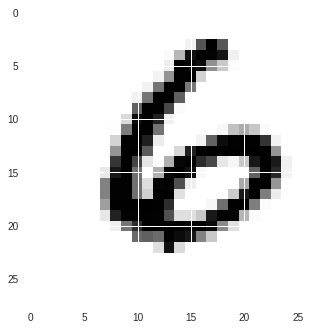

In [0]:
# visualize and understand the data
for inputs, targets in scratch_loader:
    #print(f"This is the shape of one batch {inputs.shape}. What is the meaning of each dimension?  batch size * channels * height * width")
    print("target", targets.shape, list(targets))
    img = inputs[0,0]
    print(img.shape)
    plt.imshow(img)
    print(targets[0])
    break

## Description of our CNN

Hereby is a brief overview of our model. For more details, please refer to the exact model that follows.

We used a CNN with four convolutional and two fully connected layers.  We chose kernel of size 5x5 for our convolutions with padding of 2 and stride of 1. BatchNorm was used to facilitate training of the network after each convolution, and then passed on to a relu activation function. Max pooling with a filter of size 2x2 and a stride of 2 after the second and the fourth convolutions changed the dimensions origininally of 28x28x1 down to 7x7x128. The number of channels for the convolutions are (32,64,64,128). The output of the last convolution is flattened, and the next hidden unit has size 50. This was then passed into a fully connected layer with 10 outputs, one for each digit. Loss was calculated using cross entropy loss witch includes softmax.

The resulting CNN had a total of 674,224 parameters.

In [0]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        
        self.block0 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.block1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64,64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc1 = nn.Linear(7*7*128, 50)
        
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
      
        out = self.block0(x)
      
        out = self.block1(out)

        out = self.block2(out)
        
        out = self.block3(out)
        
        # Flatten the output of block2
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        
        out = self.fc2(out)
        
        return out
        
model = NN()
model = model.to(device)

print(model)
print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

NN(
  (block0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [0]:
# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

# spot to save your learning curves, and potentially checkpoint your models
#savedir = 'results'
#if not os.path.exists(savedir):
#    os.makedirs(savedir)

In [0]:
def train(model,train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    train_loss = 0
    correct = 0
    train_size = 0
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
        
        # Let them code what's here
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        ###
        #train_size += len(inputs)
        #train_loss += test_loss_fn(output, target).item() # sum up batch loss
        #pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        #correct += pred.eq(target.view_as(pred)).sum().item()
        
        
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))
            
    #train_loss /= train_size
    #accuracy = correct / train_size
    #print('\Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #train_loss, correct, train_size,
        #100. * accuracy))
    
    #return train_loss, accuracy

In [0]:
def test(model, test_loader, split="test"):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    with torch.no_grad():
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            
            # let them code what's here
            output = model(inputs)
            test_size += len(inputs)
            test_loss += test_loss_fn(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    
    print('\n' + split + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

In [0]:
start_time = time.time()

model = NN().to(device)

lr = 0.000015
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=lr)

results_train = {'loss': [], 'accuracy':[]}
results_test = {'loss': [], 'accuracy':[]}

#savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

#torch.manual_seed(0)

num_epochs = 10
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, epoch)
    loss_train, acc_train = test(model, train_loader, "train")
    loss_test, acc_test = test(model, test_loader)
    
    # save results every epoch
    results_train['loss'].append(loss_train)
    results_train['accuracy'].append(acc_train)
    
    results_test['loss'].append(loss_test)
    results_test['accuracy'].append(acc_test)
    #with open(savefile, 'wb') as fout:
        #pickle.dump(results, fout)
      
total_time = time.time() - start_time

print("Total time to train and evaluate at each each epoch: {0:.0f} seconds".format(total_time))


Train Epoch: 1 [0/50048 (0%)]	Loss: 2.335327
Train Epoch: 1 [6400/50048 (13%)]	Loss: 1.433928
Train Epoch: 1 [12800/50048 (26%)]	Loss: 0.750030
Train Epoch: 1 [19200/50048 (38%)]	Loss: 0.461005
Train Epoch: 1 [25600/50048 (51%)]	Loss: 0.377401
Train Epoch: 1 [32000/50048 (64%)]	Loss: 0.311611
Train Epoch: 1 [38400/50048 (77%)]	Loss: 0.230419
Train Epoch: 1 [44800/50048 (90%)]	Loss: 0.144785

train set: Average loss: 0.1744, Accuracy: 48139/50000 (96.28%)


test set: Average loss: 0.1626, Accuracy: 9647/10000 (96.47%)

Train Epoch: 2 [0/50048 (0%)]	Loss: 0.285443
Train Epoch: 2 [6400/50048 (13%)]	Loss: 0.180010
Train Epoch: 2 [12800/50048 (26%)]	Loss: 0.084520
Train Epoch: 2 [19200/50048 (38%)]	Loss: 0.150021
Train Epoch: 2 [25600/50048 (51%)]	Loss: 0.070973
Train Epoch: 2 [32000/50048 (64%)]	Loss: 0.156258
Train Epoch: 2 [38400/50048 (77%)]	Loss: 0.118181
Train Epoch: 2 [44800/50048 (90%)]	Loss: 0.220925

train set: Average loss: 0.0894, Accuracy: 48898/50000 (97.80%)


test set: Avera

## Train and Validation Losses

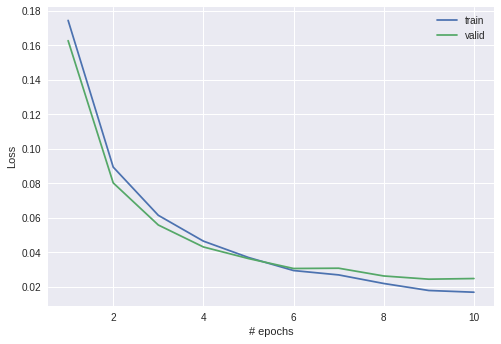

In [0]:
# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, results_train["loss"], label='train')
plt.plot(x, results_test["loss"], label='valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Train and Validation Accuracies

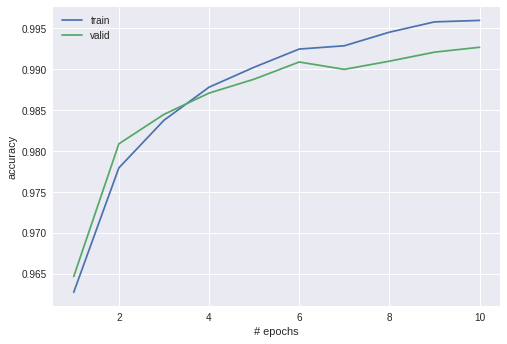

In [0]:
# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, results_train["accuracy"], label='train')
plt.plot(x, results_test["accuracy"], label='valid')

plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

## The performances of CNN vs MLP

We trained both the MLP and the CNN for exactly 10 epochs. Despite both models having around 670,000 parameters, the training of the MLP takes around 50 minutes, and the CNN needs less than 6 minutes. The main difference the MLP is a lot slower is that it uses a CPU, which a lot slower than the GPU used by our CNN.
The testing error for the MLP is around 1.8%, which is more than twice the testing error of 0.73% for the CNN. The latter is better because it uses local spatial coherence, which is impossible with the former. Of course, the MLP has only 2 hidden layers. The CNN, with 4 hidden layers, has an advantage here. But we tried several CNNs with only two hidden layers, and the testing errors were still around 1%.
Despite the simplicity of the MNIST dataset, this shows the advantage of the CNN over the MLP for image recognition.